## RAMA 2: Vamos a estudiar el hamiltoniano asociado a una cadena de moléculas con interacción dipolar. 

In [76]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from qutip import *
from qutip import (about, destroy, entropy_vn, expect, hinton, jmat, ptrace, qeye, steadystate, tensor, wigner)
from mpl_toolkits.mplot3d import Axes3D # hacer gráfico 3Dfrom numpy import *
%matplotlib inline 
#%matplotlib notebook

In [77]:
def a0(x): #esta función convierte una distancia x en metros a unidades atómicas a_0
    return x/(5.29177249e-11) 
#########

def tau(t): #convertir de segundos a tiempo en unidades atómicas
    return t/2.418884332268184938e-17

##################

def dby(d): #d está en debyes, pasamos a unidades atómocas ea_0
    return (d*0.393430307)


def fre(f): #se ingresa la frecuencia como energía en eV se convierte a hartrees. 
    
    return f/ 27.211386245988

In [78]:
#parámetros del sistema
L=6
K=10
M=(L-2)*K+2
N=10

#parámetros de la nanoesfera

omega_p=fre(6.278) #se ingresa en eV, luego se transforma en Hartrees. 
R=a0(18e-9)  #este radio está asociado a la frecuencia de resonancia de la metilamina. 

#parámetros de las moléculas
omega_m=omega_p
epsilon_2=6.29

d=dby(1.811)  #el dipolo se ingresa en debyes

#paŕametros de la red

r=a0(6.27e-10)    # separación horizontal entre dipolos 

y=R+0.5*r    #distancia vertical entre el centro de la nano esfera y la línea en dónde están ubicados 
#los dipolos 

In [120]:
def posiciones (y, L, K):

    r=[[0,0,y]] #siembre habrá un dipolo en la parte superior de la esfera

    phi=np.linspace(0, np.pi, L)[1:-1]
    theta=np.linspace(0,2*np.pi, K+1)[:-1]

    for i in phi:
        for j in theta:
            X=y*np.sin(i)*np.cos(j)
            Y=y*np.sin(i)*np.sin(j)
            Z=y*np.cos(i)
            r.append([X,Y,Z])
       

    r.append([0,0,-y]) #siempre habrá un dipolo en la parte inferior de la esfera

    return np.array(r)


# Función para encontrar los vectores aleatorios que definen cada momento

In [80]:
def Momentos(M): #función que entrega un vector que en cada componente tiene las componentes x,y,z 
    #del vector unitario que determina cada dipolo en una red de N dipolos.
    
    momentos=[]
    
    for i in range (M):
        #ahora vamos a determinar las direcciones aleatorias theta y phi de cada dipolo
        np.random.seed()
        theta=np.random.uniform(0, np.pi)
        phi=np.random.uniform(0, 2*np.pi)

        x1=np.sin(theta)*np.cos(phi)
        y1=np.sin(theta)*np.sin(phi)
        z1=np.cos(theta)

        momentos.append([x1,y1,z1]) #vector que en cada componente tiene en ángulo theta y phi asociado 
    return (np.real(momentos))

In [81]:
momentos=Momentos(M)
P=posiciones(y, L, K)

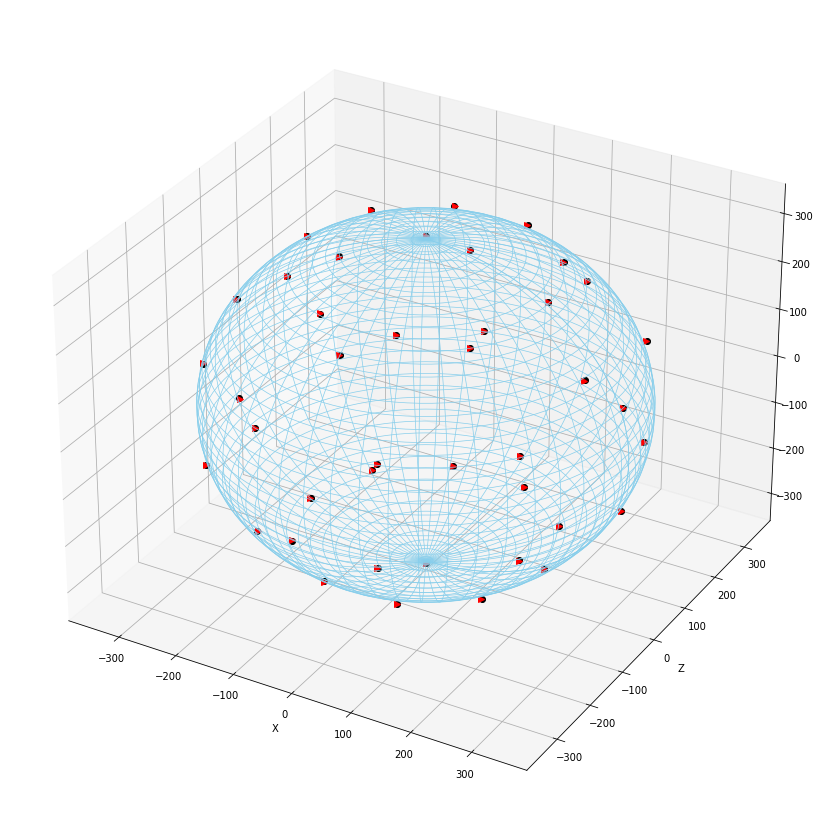

In [82]:
fig, ax=plt.subplots(figsize=(15,15), subplot_kw=dict(projection='3d'))


#graficamos la nanoesfera
theta=np.linspace(0,np.pi,100)
phi=np.linspace(0,2*np.pi,100)

Theta,Phi=np.meshgrid(theta,phi)

X=R*np.sin(Theta)*np.cos(Phi) 
Y=R*np.sin(Theta)*np.sin(Phi)
Z=R*np.cos(Theta)

ax.plot_wireframe(X,Y,Z,lw=0.7, color='skyblue') #dibujamos el casquete esférico

#graficamos los dipolos y su dirección
for i in range (len(P)): #en P están los centros de masa de los momentos
    #en momentos está el vector del momento. 
    
    x1=momentos[i][0]+P[i][0]
    y1=momentos[i][1]+P[i][1]
    z1=momentos[i][2]+P[i][2]

    ax.plot((P[i][0],),(P[i][1],), (P[i][2],), marker='o',c='k') #dibujamos el centro del dipolo
    ax.plot((P[i][0], x1 ) ,(P[i][1],y1), (P[i][2],z1  ),  c='r') #dibujamos la línea
    ax.plot((x1,),(y1,),(z1,),'->',c='r') #dibujamos la dirección
    
 

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_ylabel('Z')
plt.show()

# Función para determinar $\hat{\sigma}_+, \hat{\sigma}_-, \hat{\sigma}_3$ de cada dipolo

In [83]:
def sigmaT(M,N):
    l = 2  # number of levels per dipole
    Sigma = []
    for i in range(M):
        operators = []
        for j in range(M): #si el índice es igual a la matrix que quiero entonces pongo el destroy 
            #de resto pongo el qeye, luego al final pongo la matriz unitaria asociada a la radiación.
            if j != i:
                operators.append(qeye(l))
            else:
                operators.append(destroy(l))
        
        operators.append(qeye(N+1))
        sigma_plus=tensor(operators)
        Sigma.append(np.array(sigma_plus))

    return np.real(Sigma)

In [84]:
def Base(M,N):
    B=np.eye(2**M*(N+1))
    return np.linalg.eig(B)[1]

# 

\begin{align}
    \hat{H}_{dip}= \frac{\omega_m}{2} \sum_{j=1}^{M} \hat{\sigma}_{3j}
\end{align}

In [85]:
def Hdip0_(sigma):
    
    s=sigma.shape
    H_0=np.zeros((s))

    sp=sigma
    sm=np.transpose(sp)
    H_0+=sp@sm-sm@sp
        
    return (0.5*omega_m*H_0 )

In [86]:
def Hdip0(M, sigmas):
    
    s=sigmas[0].shape
    H_0=np.zeros((s))
    
    for i in range (M):
        sp=sigmas[i]
        sm=np.transpose(sp)
        H_0+=sp@sm-sm@sp
        
    return (0.5*omega_m*H_0 )


En los productos tensoriales que siguen primero se pone por convención la parte de materia y por último la parte de radiación. 

En la práctica el producto tensorial se hace en dirección inversa. 

In [87]:
def aT(M,N): #función que entrega la representación matricial del operador a en la base de 
    #N fotones y M dipolos. 
    L=[]
    for i in range(M):
        L.append(qeye(2))
    L.append(destroy(N+1))
    a=tensor(L) #el producto tensorial lo hace desde el último hasta el primero. 
    return (np.real(np.array(a)))

# hamiltoniano radiación-materia  en la base completa

### 

\begin{align} 
 \hat{H}_{tot}= \frac{\omega_m}{2} \sum_{i=1}^{  M } \hat{\sigma}_{3j}+\omega_p \hat{a}^{\dagger}\hat{a} + \frac{3}{2}d\sqrt{\frac{3 \omega_p R^3}{
  (2\epsilon_2+1)^{3/2}}} \left[\sum_{i=1}^{M}\sum_{\hat{k}=\hat{x}, \hat{y}, \hat{z}} \frac{ (3 \cos \theta_{0_ik} \cos \theta_{0_id_i}-\cos \theta_{d_ik}) }{r_{0d_i}^3}(\hat{\sigma}_{+i}+\hat{\sigma}_{-i}) \right ] (\hat{a}+\hat{a}^\dagger) 
\end{align}

In [88]:
def Hrad0(a):
    return omega_p*(np.transpose(a)@a)

In [89]:
def HradI_(i, momento, sigma, P, a):
    
    K=np.array([[1,0,0], [0,1,0],[0,0,1]])
    
    H_rad1=np.zeros(sigma.shape)
    
    p= P/y
    m=momento
    sp=sigma
    sm=np.transpose(sp)
    
    anda=0
    
    for k in K:
        anda+=3*np.dot(p,k)*np.dot(p,m)-np.dot(m,k)
        

    landa=(3/2)*d*np.sqrt((3*omega_p*R**3)/(2*epsilon_2+1)**(3/2))*(1/y**3)*anda
    H_rad1+=landa*(sm+sp)
      
    return ( np.real( H_rad1@(a+np.transpose(a))), landa)

In [165]:
def HradI(M, momentos, sigmas, P, a, y):
 
    K=np.array([[1,0,0], [0,1,0],[0,0,1]])
    H_rad1=np.zeros((sigmas[0].shape))
    anda=[]
    for i in range(M):
        p= (1/y)*P[i]
        m=momentos[i]
        sp=sigmas[i]
        sm=np.transpose(sp)

        Landa=0

        for k in K:
            Landa+=3*np.dot(p,k)*np.dot(p,m)-np.dot(m,k)
      
        landa=(3/2)*d*np.sqrt((3*omega_p*R**3)/(2*epsilon_2+1)**(3/2))*(1/y**3)*Landa
        
        H_rad1+=landa*(sm+sp)

        anda.append(landa)

    return ( np.real( H_rad1@(a+np.transpose(a))), anda )

In [166]:
#parámetros del sistema
L=3
K=4
M=(L-2)*K+2
print(M)
N=5

#parámetros de la nanoesfera

omega_p=fre(6.278) #se ingresa en eV, luego se transforma en Hartrees. 
R=a0(18e-9)  #este radio está asociado a la frecuencia de resonancia de la metilamina. 

#parámetros de las moléculas
omega_m=omega_p
epsilon_2=6.29

d=dby(1.811)  #el dipolo se ingresa en debyes

#paŕametros de la red

r=a0(6.27e-10)    # separación horizontal entre dipolos 

y=R+0.5*r    #distancia vertical entre el centro de la nano esfera y la línea en dónde están ubicados 
#los dipolos 

6


In [167]:
momentos=Momentos(M)
sigmas= sigmaT(M,N)
P=posiciones(y, L, K)
a=aT(M,N)

In [163]:
U0=Hdip0(M, sigmas)
U1=Hrad0(a)
U2=HradI(M, momentos, sigmas, P, a, y)[0]
U=U0+U1+U2
E=np.linalg.eigvals(U)

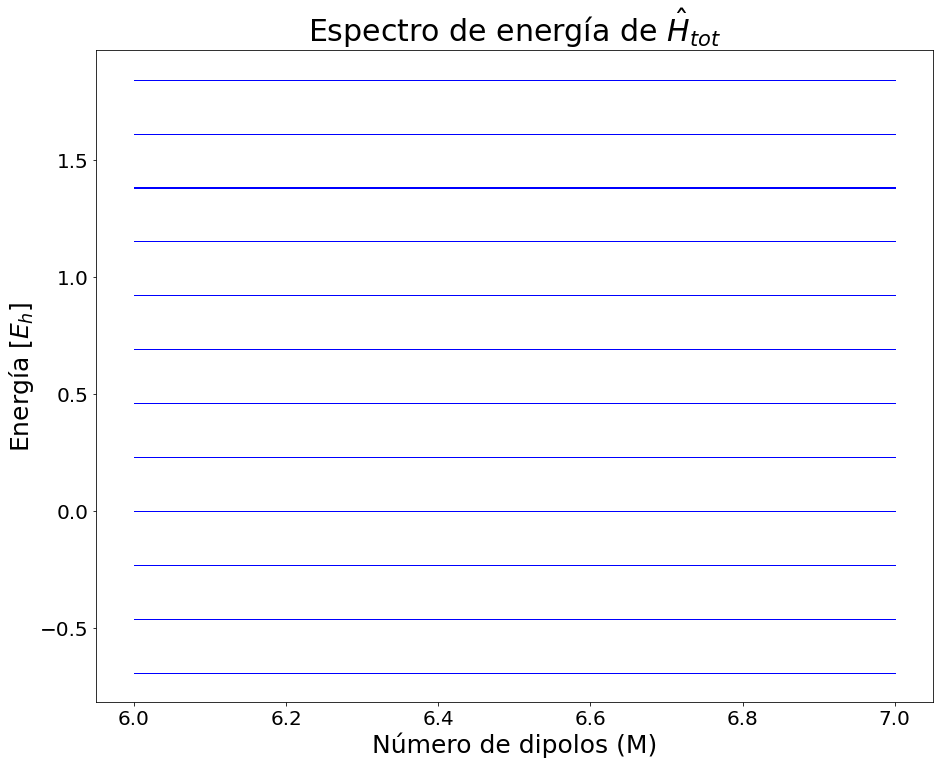

In [164]:
fig1,ax1=plt.subplots(1,1,figsize=(15,12))

for j in range(len(E)):
    y=E[j]
    X=[M, M+1]
    #X=[int(i), int(i+1)]
    ax1.plot(X,[y,y], c='blue', lw=1)
        
ax1.set_xlabel('Número de dipolos (M)', fontsize=25)
ax1.set_ylabel('Energía $[E_h]$', fontsize=25)
ax1.set_title('Espectro de energía de $\hat{H}_{tot}$', fontsize=30)


ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

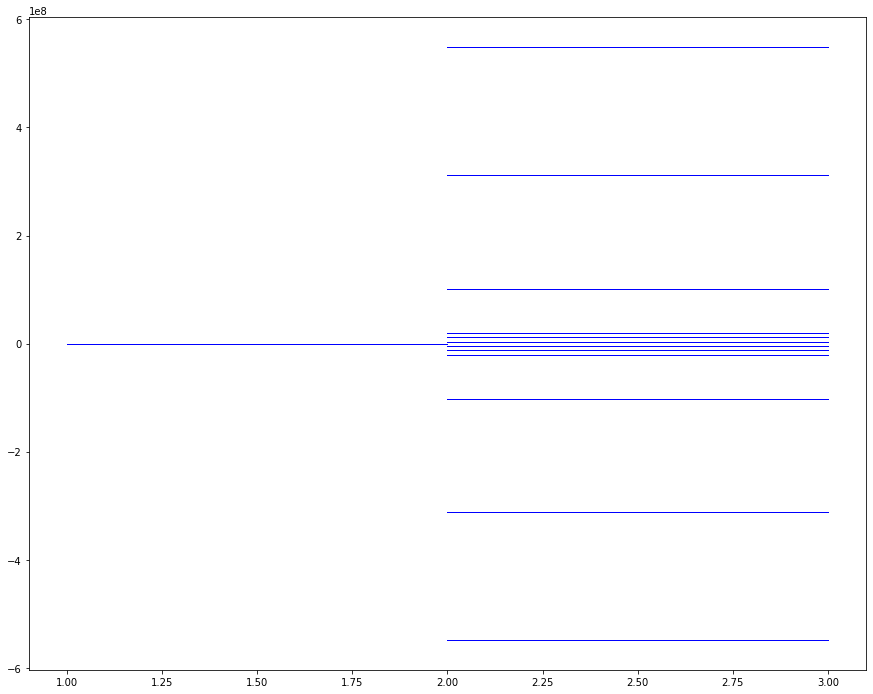

In [168]:

U1=Hrad0(a)

fig1,ax1=plt.subplots(1,1,figsize=(15,12))

for i in range (1,M+1):

    U0=Hdip0(i, sigmas)
    U2=HradI(i, momentos, sigmas, P, a, y)[0]

    U=U0+U1+U2
    E=np.linalg.eigvals(U)
    
    for j in range(len(E)):
        y=E[j]
        X=[int(i), int(i+1)]
        ax1.plot(X,[y,y], c='blue', lw=1)
        
ax1.set_xlabel('Número de dipolos (M)', fontsize=25)
ax1.set_ylabel('Energía $[E_h]$', fontsize=25)
ax1.set_title('Espectro de energía de $\hat{H}_{tot}$', fontsize=30)


ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

#ax1.set_ylim(0.10, 0.12)

plt.show()

Si no tengo strong coupling entonces no puedo afirmar que se forman polaritones. El factor de acople no depende del número de fotones.  El hamiltoniano total y el de radiación son casi lo mismo, es decir que el hamiltoniano de interacción dipolar lo podemos considerar como una perturbación

## Evolución temporal

In [91]:
hc=1.98644586e-25
E=1.005846e-18
print( (hc/E))

1.974900591144171e-07


La longitud de onda de la radiación resonante con los estados HOMO-LUMO es:

## $$197.49~nm \rightarrow DUV$$

In [129]:
# Definimos el tiempo
M=3
N=5
t =np.linspace(0, 42, 84) #42tau=1f segundo
B=Base(M,N)
psi0=B[(len(B)-1)-N] #todos los subsistemas inician en el mismo estado |g1g2...gM,0>, el de más baja energía. 
sigmas=sigmaT(M, N)
P=posiciones(M,r,y)
a=aT(M, N)

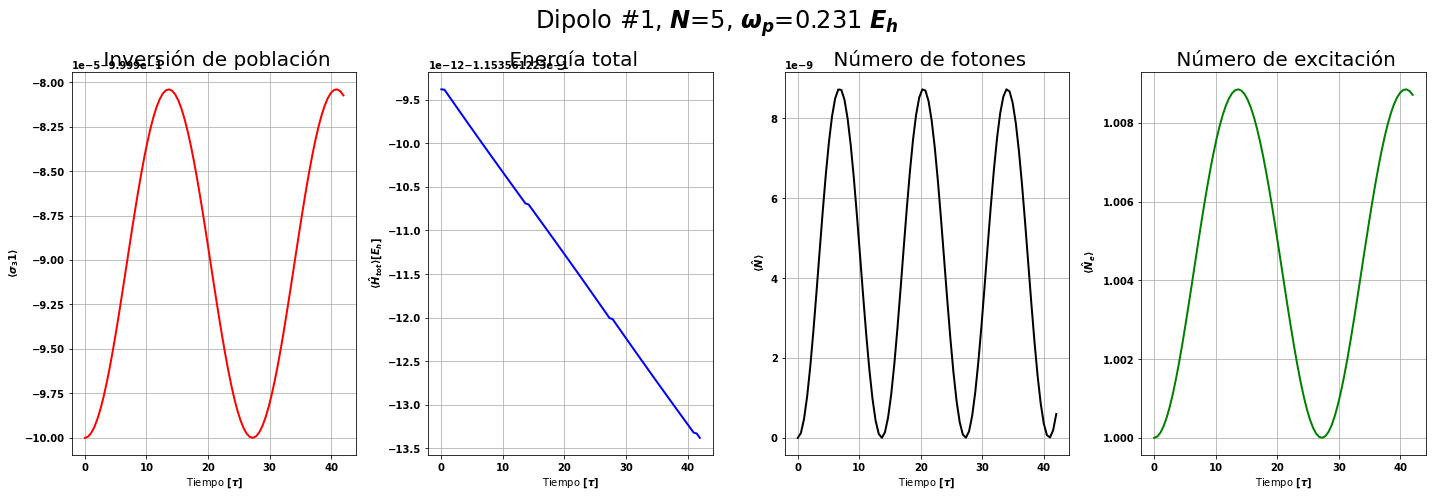

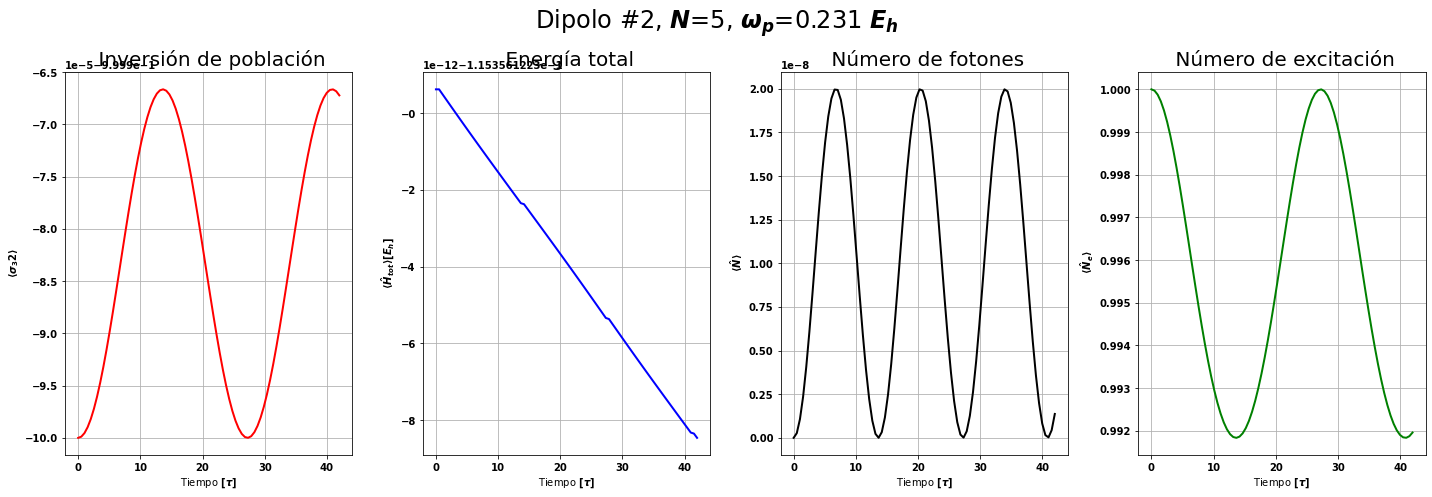

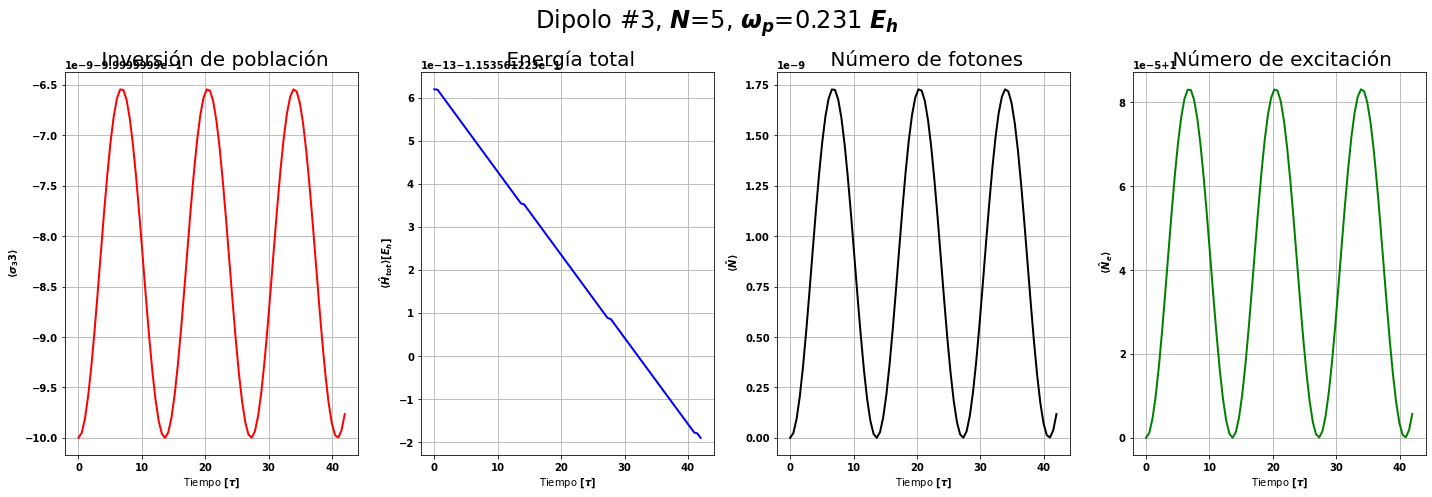

In [130]:
U2=Hrad0(a) #radiación en la cavidad

for i in range(M): #queremos estudiar casa sistema por serado
    
    sp=sigmas[i]
    sm=np.transpose(sp)
    s3=sp@sm-sm@sp
    PP=P[i]
    momento=momentos[i]
    
    n=np.transpose(a)@a
    N_e=n+B[N]@np.transpose(B[N])

    #el hamiltoniano de cada subsistema consistiría en quitar la sumatoria, todos parten del mismo estado. 
    

    U0=Hdip0_(sp) #solo dipolos
    U1=HdipI_(i, M, sigmas, momentos, u, p) #energía de interacción entre dipolos
    U3=HradI_(i, momento, sp, PP,a)[0] #interacción radiación dipolos
    U4=U0+U1+U2+U3



    result=mesolve( Qobj(U4), Qobj(psi0), t, [], [Qobj(s3), Qobj(U4), Qobj(n), Qobj(N_e) ]  )

    
    fig, ax=plt.subplots(1,4, figsize=(20,7))
    
    fig.suptitle(r"Dipolo #{}, $N$={}, $\omega_p$={} $E_h$".format(i+1, N, np.round(omega_p,3)), fontsize=24)

    ax[0].plot(t, result.expect[0], label=r"$\langle \sigma_3{} \rangle$".format(i+1),c='r',lw=2)
    ax[0].set_title(" Inversión de población", fontsize=20)
    ax[0].set_xlabel(r"Tiempo $[\tau]$")
    ax[0].set_ylabel(r" $\langle \sigma_3{} \rangle$".format(i+1))
    ax[0].grid()
    plt.tight_layout()



    ax[1].plot(t, result.expect[1], label=r"$\langle \hat{H}_{tot} \rangle$",c='b',lw=2)
    ax[1].set_title(" Energía total", fontsize=20)
    ax[1].set_xlabel(r"Tiempo $[\tau]$")
    ax[1].set_ylabel(r" $\langle \hat{H}_{tot} \rangle [E_h]$")
    ax[1].grid()
    plt.tight_layout()

    ax[2].plot(t, result.expect[2], label=r"$\langle \hat{a}^\dagger \hat{a} \rangle$",c='k',lw=2)
    ax[2].set_title(" Número de fotones", fontsize=20)
    ax[2].set_xlabel(r"Tiempo $[\tau]$")
    ax[2].set_ylabel(r" $\langle \hat{N} \rangle$")
    ax[2].grid()
    plt.tight_layout()


    ax[3].plot(t, result.expect[3], label=r"$\langle \hat{N}_e \rangle$",c='g',lw=2)
    ax[3].set_title(" Número de excitación", fontsize=20)
    ax[3].set_xlabel(r"Tiempo $[\tau]$")
    ax[3].set_ylabel(r" $\langle \hat{N}_e \rangle$")
    ax[3].grid()
    plt.tight_layout()

    plt.show()
                